In [1]:
import os
import time
import datetime
from itertools import chain
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
    precision_score,
    recall_score,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from group_lasso import GroupLasso, LogisticGroupLasso

# Current folder
path = os.getcwd()
data_path = os.path.join(path, "Data")

In [2]:
# confusion matrix with headers
def confusion_matrix_with_headers(y_true, y_pred):
    # y_true is the true labels
    # y_pred is the predicted labels
    # return the confusion matrix with headers

    # create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # create the header
    header = ['Predicted 0', 'Predicted 1']

    # create the index
    index = ['Actual 0', 'Actual 1']

    # create the dataframe
    df_cm = pd.DataFrame(cm, columns=header, index=index)

    # return the dataframe
    return df_cm

# Dataset

## Loading

In [3]:
# import the dataset called Swarm_Behaviour
df_merged = pd.read_csv(os.path.join(data_path, "Swarm_Behaviour.csv"))

# print the shape of the dataset
print("The shape of the dataset merged is: ", df_merged.shape)

# show the first 5 rows of the dataset
df_merged.head()

The shape of the dataset merged is:  (23309, 2401)


,x1,y1,xVel1,yVel1,xA1,yA1,xS1,yS1,xC1,yC1,...,yVel200,xA200,yA200,xS200,yS200,xC200,yC200,nAC200,nS200,Swarm_Behaviour
0,562.05,-0.62,-10.70,-4.33,0.00,0.00,0.0,0.0,0.00,0.00,...,-15.15,0.00,0.00,0.00,0.00,0.00,0.0,28,0,0.0
1,175.66,-57.09,2.31,-2.67,0.00,0.00,0.0,0.0,0.00,0.00,...,-3.48,0.00,0.00,0.00,0.00,0.00,0.0,4,0,0.0
2,200.16,-320.07,4.01,-6.37,0.00,0.00,0.0,0.0,0.18,-0.26,...,-9.38,0.00,0.00,0.00,0.00,-0.11,-0.3,15,1,0.0
3,316.99,-906.84,0.85,9.17,-0.17,1.03,0.0,0.0,0.00,0.00,...,10.39,-0.26,1.01,0.00,0.00,0.00,0.0,16,0,0.0
4,1277.68,908.54,-2.02,8.23,-1.00,1.00,0.0,0.0,0.00,0.00,...,13.91,-1.00,0.00,3.21,15.67,0.00,0.0,12,0,0.0


## Analysis of a random row

First of all we select a random row and we create a dataset from it.

In [4]:
selected_class = 1
row_line = df_merged[df_merged['Swarm_Behaviour'] == selected_class].sample(1)

# every row represents a sample of 200 boids, we want to study this specific sample
# we create a dataset with 12 columns (measures) and 200 rows (boids) from row

# extract the first 12 indices of the row
features = [i[:-1] for i in row_line.columns[:-1][:12]]

# define the dataframe df_selected_row
row = pd.DataFrame(columns=features)

for i in range(200):
    # Adjust the slicing logic based on the structure of your row data
    row.loc[i] = row_line.iloc[:,12*i:12*(i+1)].values.flatten()

### Scatter plot of the positions

The behavior of the swarm of the selected row is:  1


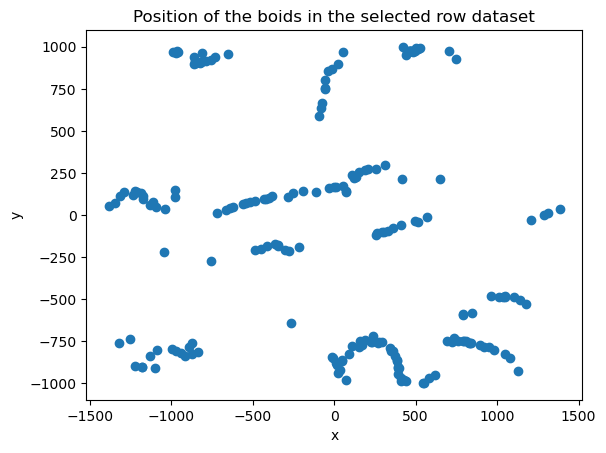

In [5]:
# print the last element of row
print("The behavior of the swarm of the selected row is: ", selected_class)

# Plot the position of the boids (x, y) in the selected row dataset
plt.scatter(row['x'], row['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Position of the boids in the selected row dataset')

# Show the plot
plt.show()

### Quiver plot of the vectors

A random row corresponds to an instantaneous picture of the state of the 200 boids. A real person has classified the behaviour of the swarm with 1 or 0 as if it appears flocking, aligned and grouped or not. Let's look at some of those images. 

In [6]:
def visualize_boids(row, selected_class):
    # row is a dataframe with 12 columns and 200 rows

    # print the last element of row
    print("The behavior of the swarm of the selected row is: ", selected_class)

    # Set up subplots in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Plot the velocity of the boids (xVel, yVel) as vectors pointing from the point (x, y) in the selected row dataset
    axs[0, 0].quiver(row['x'], row['y'], row['xVel'], row['yVel'],
                     color='blue', label='Velocity Vector')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('y')
    axs[0, 0].set_title('Velocity of the boids in the selected row dataset')
    axs[0, 0].legend()

    # Plot the alignment vectors (xA, yA) as vectors
    axs[0, 1].quiver(row['x'], row['y'], row['xA'], row['yA'],
                    color='red', label='Alignment Vector')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('y')
    axs[0, 1].set_title('Alignment Vectors of the Boids in the Selected Row Dataset')
    axs[0, 1].legend()

    # Plot the separation vectors (xS, yS) as vectors
    axs[1, 0].quiver(row['x'], row['y'], row['xS'], row['yS'],
                    color='purple', label='Separation Vector')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('y')
    axs[1, 0].set_title('Separation Vectors of the Boids in the Selected Row Dataset')
    axs[1, 0].legend()

    # Plot the cohesion vectors (xC, yC) as vectors
    axs[1, 1].quiver(row['x'], row['y'], row['xC'], row['yC'],
                    color='green', label='Cohesion Vector')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('y')
    axs[1, 1].set_title('Cohesion Vectors of the Boids in the Selected Row Dataset')
    axs[1, 1].legend()

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

Important observations: sometimes vectors in the following plots do not appear since they are 0 in the dataset!

### Distribuions of the vectors

In [7]:
def distribution_boids(row, selected_class):
    # row is a dataframe with 12 columns and 200 rows
    
    # print the last element of row
    print("The behavior of the swarm of the selected row is: ", selected_class)

    # Set up subplots in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Plot the histogram of the norm 2 of the velocity of the boids in the selected row dataset
    axs[0, 0].hist(np.sqrt(row['xVel']**2 + row['yVel']**2))
    axs[0, 0].set_xlabel('Norm 2 of the velocity')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].set_title('Histogram of the norm 2 of the velocity of the boids')

    # Plot the histogram of the norm 2 of the alignment vectors (xA, yA)
    axs[0, 1].hist(np.sqrt(row['xA']**2 + row['yA']**2), color='red', label='Alignment Vector')
    axs[0, 1].set_xlabel('Norm 2 of the alignment vectors')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].set_title('Histogram of the norm 2 of the Alignment Vectors of the Boids')

    # Plot the histogram of the norm 2 of the separation vectors (xS, yS)
    axs[1, 0].hist(np.sqrt(row['xS']**2 + row['yS']**2), color='purple', label='Separation Vector')
    axs[1, 0].set_xlabel('Norm 2 of the separation vectors')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].set_title('Histogram of the norm 2 of the Separation Vectors of the Boids')

    # Plot the histogram of the norm 2 of the cohesion vectors (xC, yC)
    axs[1, 1].hist(np.sqrt(row['xC']**2 + row['yC']**2), color='green', label='Cohesion Vector')
    axs[1, 1].set_xlabel('Norm 2 of the cohesion vectors')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_title('Histogram of the norm 2 of the Cohesion Vectors of the Boids')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

The behavior of the swarm of the selected row is:  1


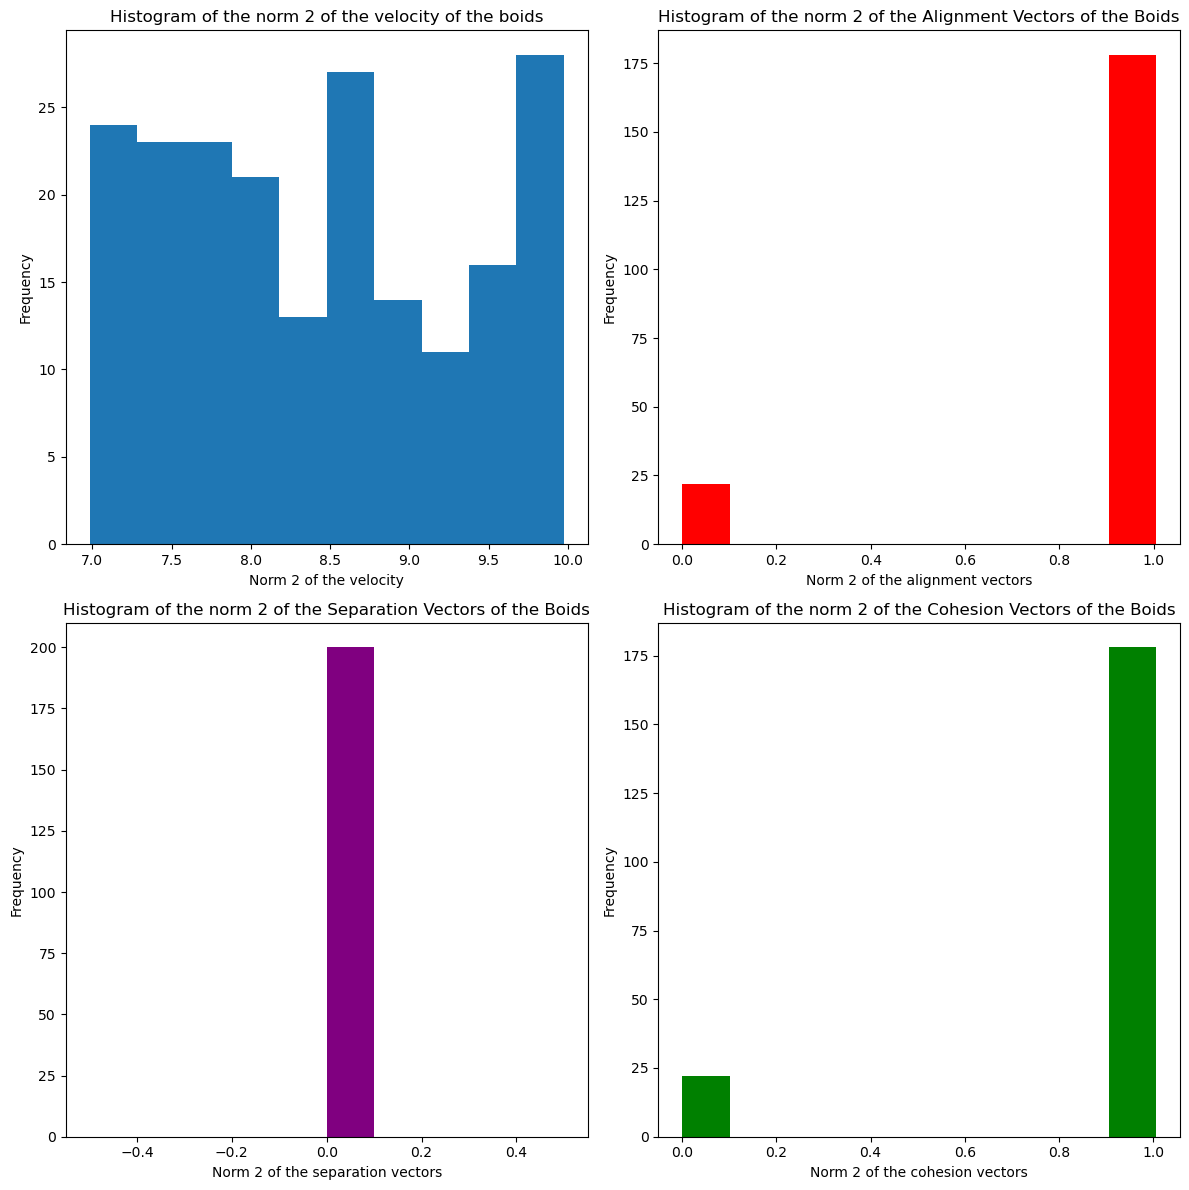

In [8]:
distribution_boids(row,selected_class=1)

### Animation 

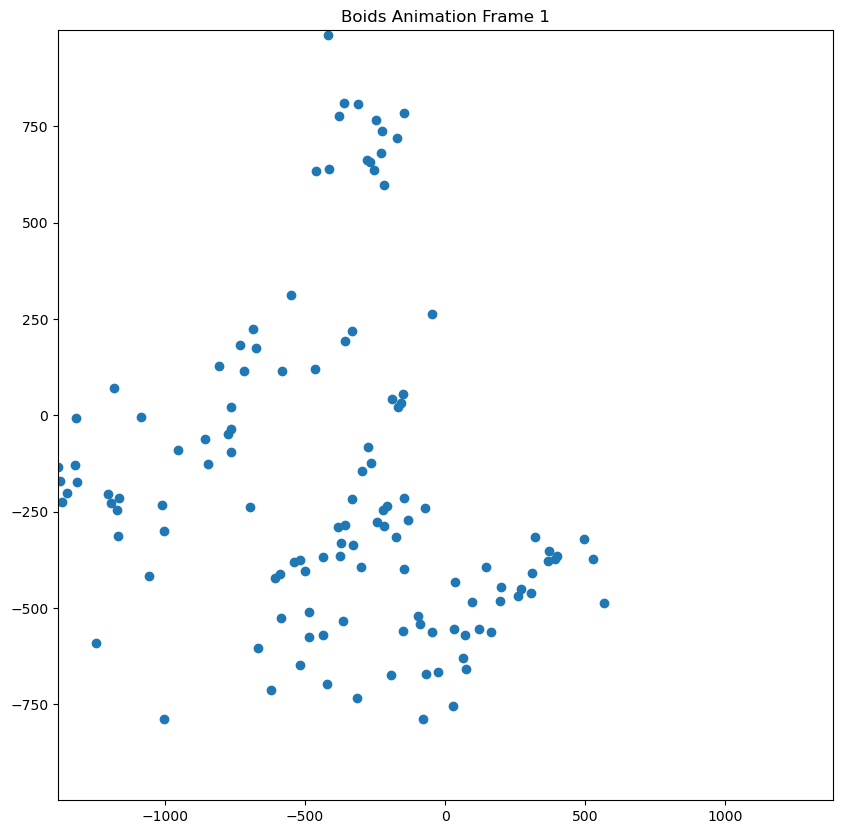

In [9]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(row['x'].min(), row['x'].max())
ax.set_ylim(row['y'].min(), row['y'].max())

# Create an initial scatter plot
scatter = ax.scatter(row['x'], row['y'])

# Function to update the plot in each animation frame
def update(frame):
    # Update the positions based on velocities
    row['x'] = row['x'] + row['xVel']
    row['y'] = row['y'] + row['yVel']

    # Update the scatter plot data
    scatter.set_offsets(np.column_stack((row['x'], row['y'])))

    plt.title('Boids Animation Frame {}'.format(frame))

# Create the animation
animation = FuncAnimation(fig, update, frames=range(1, 100), interval=50, repeat=False)

# show the animation
HTML(animation.to_html5_video())

### Visualization of nAC and nS

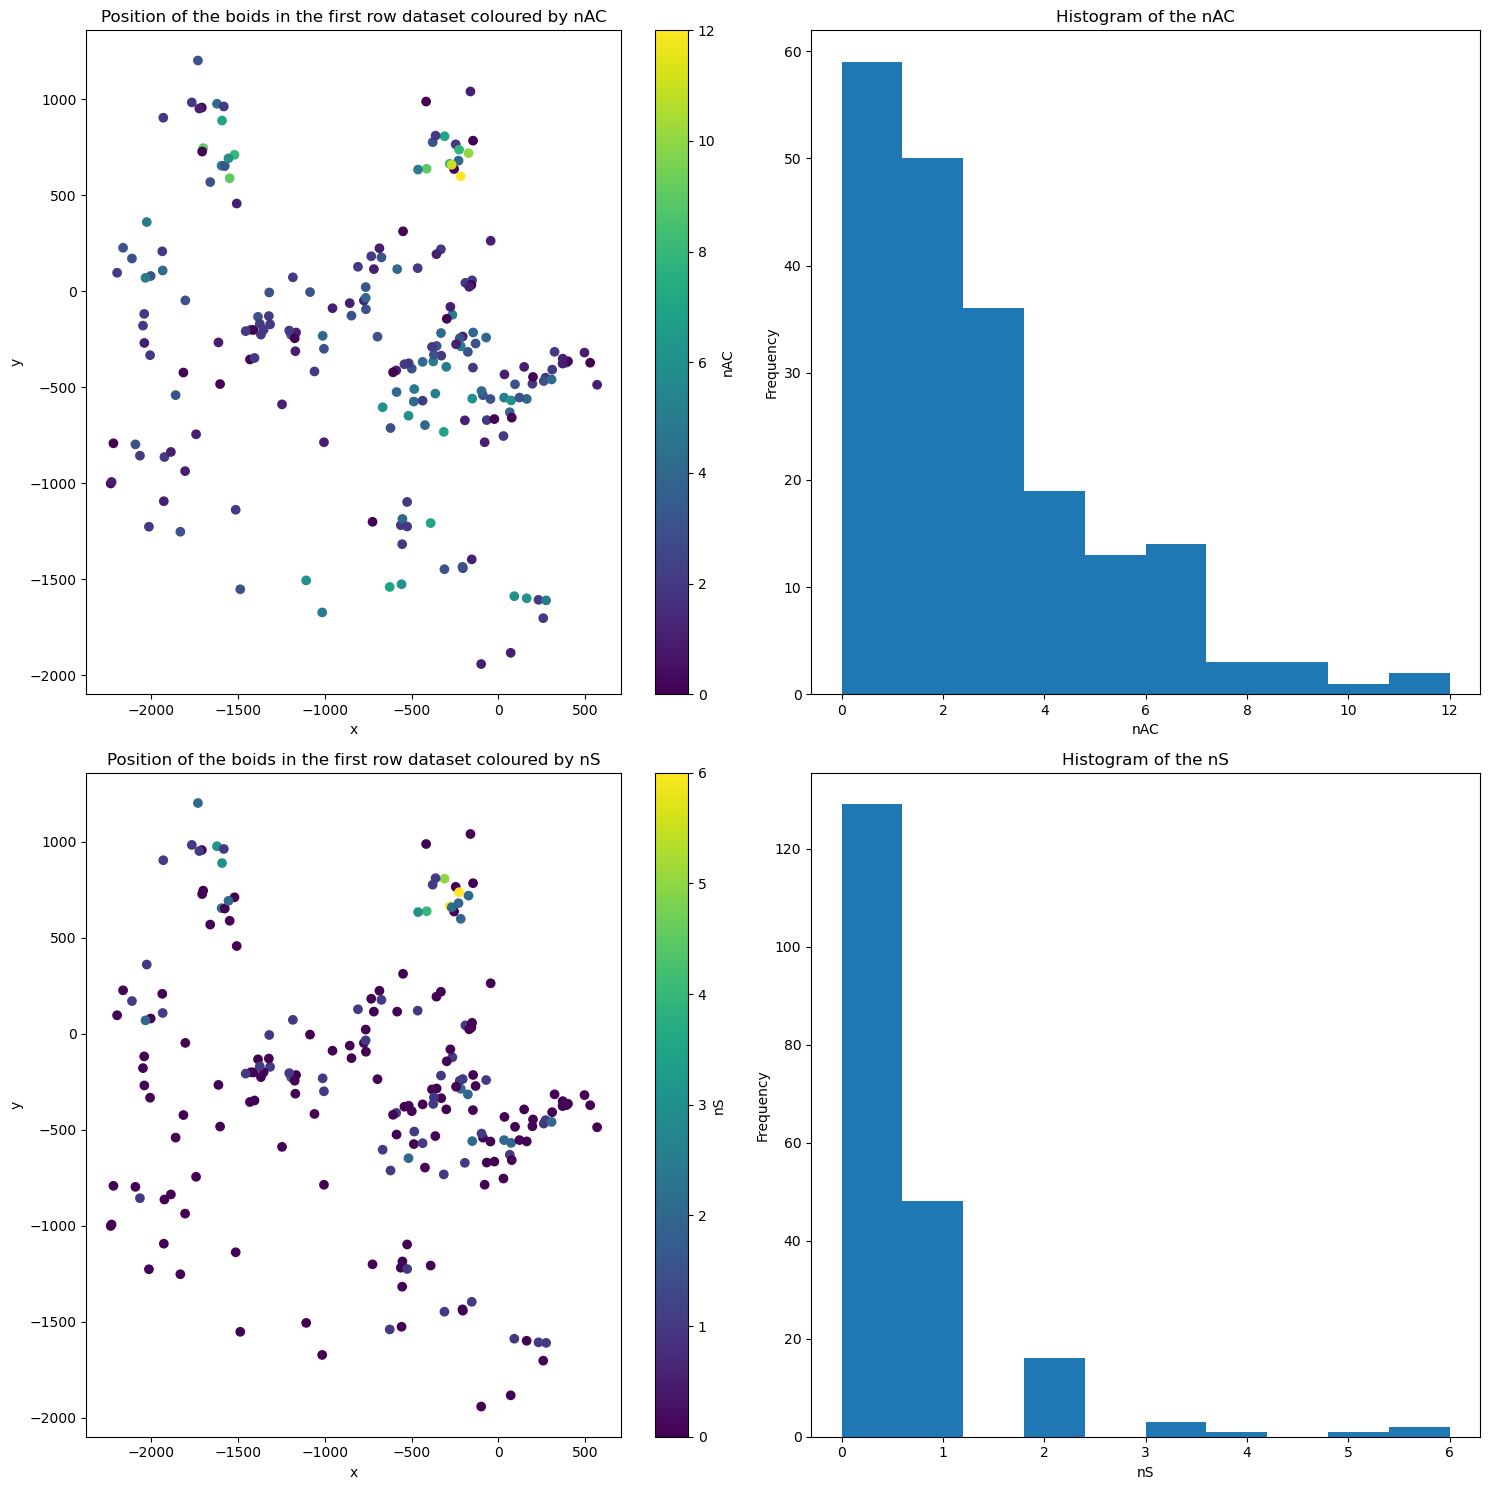

In [10]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# Plot 1: Scatter plot for nAC
scatter1 = axes[0, 0].scatter(row['x'], row['y'], c=row['nAC'])
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].set_title('Position of the boids in the first row dataset coloured by nAC')
plt.colorbar(scatter1, ax=axes[0, 0], label='nAC')

# Plot 2: Scatter plot for nS
scatter2 = axes[1, 0].scatter(row['x'], row['y'], c=row['nS'])
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
axes[1, 0].set_title('Position of the boids in the first row dataset coloured by nS')
plt.colorbar(scatter2, ax=axes[1, 0], label='nS')

# Plot 3: Histogram for nAC
axes[0, 1].hist(row['nAC'])
axes[0, 1].set_xlabel('nAC')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Histogram of the nAC')

# Plot 4: Histogram for nS
axes[1, 1].hist(row['nS'])
axes[1, 1].set_xlabel('nS')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of the nS')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


### Understanding the alignment vector

In [11]:
row.head()

,x,y,xVel,yVel,xA,yA,xS,yS,xC,yC,nAC,nS
0,-1424.36,-200.90,-8.55,-2.63,-0.96,-0.29,0.0,0.0,-0.95,-0.33,2.0,0.0
1,-1506.09,456.83,-8.43,-4.93,-0.92,-0.39,0.0,0.0,-0.96,-0.28,1.0,0.0
2,-229.97,680.04,-6.84,-2.93,-0.96,-0.27,0.0,0.0,0.30,-0.96,4.0,2.0
3,-1314.09,-172.73,-6.68,-2.10,-0.95,-0.30,0.0,0.0,-0.96,-0.29,2.0,1.0
4,-363.48,-533.17,-7.67,4.34,-0.78,0.62,0.0,0.0,-0.05,1.00,5.0,0.0


In [12]:
# creating a matrix of distances between the boids
# the matrix is symmetric and the diagonal is zero
# the matrix is 200x200
# the element (i,j) of the matrix is the distance between the boid i and the boid j
# the distance is the norm 2 of the difference of the positions of the two boids

# initialize the matrix of distances
distances = np.zeros((200,200))

# fill the matrix of distances
for i in range(200):
    for j in range(200):
        # compute the norm 2 of the difference of the positions of the two boids
        distances[i,j] = np.linalg.norm(row.iloc[i,:2] - row.iloc[j,:2])

# print the matrix of distances
print(distances)

[[   0.          662.78846233 1484.12356484 ...  482.5947221
  1466.60141347  952.2208958 ]
 [ 662.78846233    0.         1295.49409821 ...  775.29649374
  1197.33977676 1466.39133638]
 [1484.12356484 1295.49409821    0.         ... 1056.60392224
   185.57074365 1446.48927328]
 ...
 [ 482.5947221   775.29649374 1056.60392224 ...    0.
  1076.78855427  707.64817035]
 [1466.60141347 1197.33977676  185.57074365 ... 1076.78855427
     0.         1544.73143465]
 [ 952.2208958  1466.39133638 1446.48927328 ...  707.64817035
  1544.73143465    0.        ]]


In [13]:
# creating a function that takes as input a matrix of distances, a boid and a threshold and outputs the list of the boids that are at a distance less than the threshold from the boid

def neighbours(distances, boid, threshold):
    # distances is a matrix of distances
    # boid is the index of the boid
    # threshold is the threshold distance
    # return the list of the boids that are at a distance less than the threshold from the boid
    
    # initialize the list of neighbours
    neighbours = []
    
    # loop over the distances of the boid from the other boids
    for i in range(200):
        # if the distance is less than the threshold and the boid is not the boid itself then append the index of the boid to the list of neighbours
        if distances[boid,i] < threshold and boid != i:
            neighbours.append(i)
    
    # return the list of neighbours
    return neighbours

In [14]:
# test the function neighbours
# the boid 0 has 3 neighbours
print(neighbours(distances, 0, 200))

[3, 15, 17, 48, 66, 69, 79, 111, 133, 169, 175]


In [15]:
# creating a function which takes as input a matrix of distances, a boid and a threshold and and plots the boid in red, its neighbours highlighted in light red and the other boids in light grey

def plot_neighbours(distances, boid, threshold):
    # distances is a matrix of distances
    # boid is the index of the boid
    # threshold is the threshold distance

    # initialize the list of neighbours
    neighbours = []

    # loop over the distances of the boid from the other boids
    for i in range(200):
        # if the distance is less than the threshold and the boid is not the boid itself then append the index of the boid to the list of neighbours
        if distances[boid,i] < threshold and boid != i:
            neighbours.append(i)
    
    number = len(neighbours)
    
    # create a list of colors
    colors = ['lightgrey']*200

    # set the color of the boid to red
    colors[boid] = 'red'

    # set the color of the neighbours to light red
    for i in neighbours:
        colors[i] = 'orange'

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    a = row['x'].min()
    b = row['x'].max()
    c = row['y'].min()
    d = row['y'].max()
    up = max(b,d)+100
    down = min(a,c)-100
    ax.set_xlim(down, up)
    ax.set_ylim(down, up)

    # create an initial scatter plot
    scatter = ax.scatter(row['x'], row['y'], c=colors)

    # add a circle to highlight the threshold distance
    circle = plt.Circle((row['x'][boid], row['y'][boid]), threshold, color='red', fill=False)
    ax.add_artist(circle)

    # add the title
    plt.title('Boids ({}) whithin a distance of {} units from the boid in red with index {}'.format(number,threshold, boid))
    

    # show the plot
    plt.show()

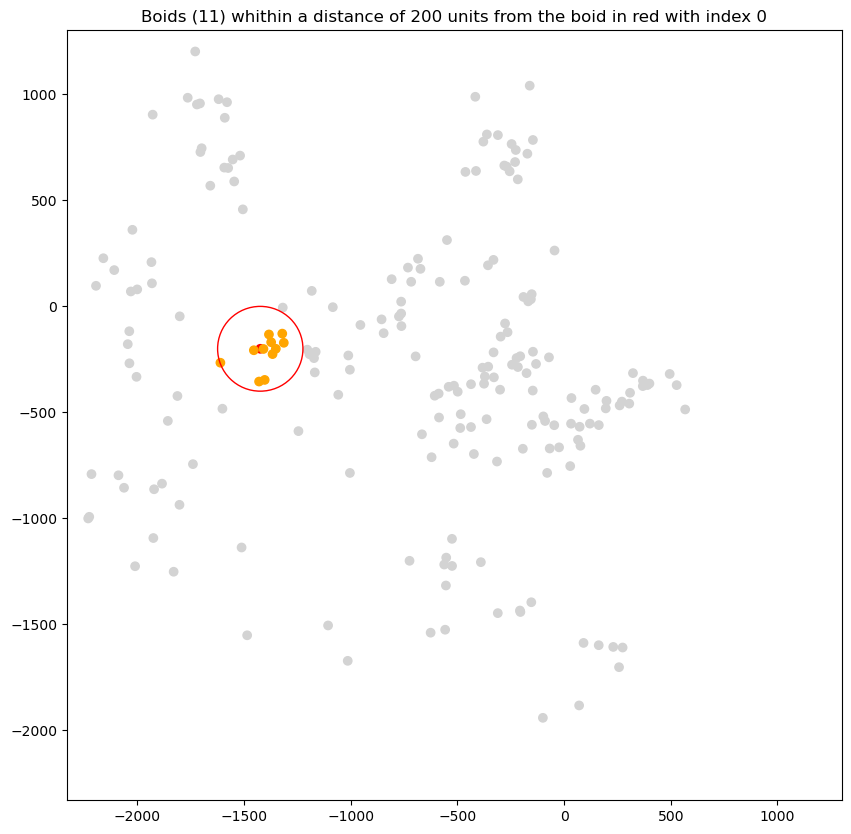

In [16]:
# test the function plot_neighbours
plot_neighbours(distances, 0, 200)

In [17]:
# creating a function which takes as input the distances matrix, a boid and a threshold and plots the boid in red, its neighbours highlighted in light red and the other boids in light grey
# then plots the velocities of the boid and its neighbours in blue and the other boids in light grey

def plot_neighbours_velocities(distances, boid, threshold):
    # df is the dataframe
    # boid is the index of the boid
    # threshold is the threshold distance

    # initialize the list of neighbours
    neighbours = []

    # loop over the distances of the boid from the other boids
    for i in range(200):
        # if the distance is less than the threshold and the boid is not the boid itself then append the index of the boid to the list of neighbours
        if distances[boid,i] < threshold and boid != i:
            neighbours.append(i)
    
    number = len(neighbours)

    # create a list of colors
    colors = ['lightgrey']*200

    # set the color of the boid to red
    colors[boid] = 'red'

    # set the color of the neighbours to light red
    for i in neighbours:
        colors[i] = 'orange'

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(row['x'].min(), row['x'].max())
    ax.set_ylim(row['y'].min(), row['y'].max())

    # create an initial scatter plot
    scatter = ax.scatter(row['x'], row['y'], c=colors)

    # add the title
    plt.title('Boids ({}) whithin a distance of {} units from the boid in red with index {} and velocities'.format(number,threshold, boid))

    # plot the velocity of the boid in red
    ax.quiver(row['x'][boid], row['y'][boid], row['xVel'][boid], row['yVel'][boid], color='red', label='Velocity Vector')

    # plot the velocity of the neighbours in orange
    for i in neighbours:
        ax.quiver(row['x'][i], row['y'][i], row['xVel'][i], row['yVel'][i], color='orange', label='Velocity Vector')

    # plot the velocity of the other boids in lightgrey
    for i in range(200):
        if i != boid and i not in neighbours:
            ax.quiver(row['x'][i], row['y'][i], row['xVel'][i], row['yVel'][i], color='lightgrey', label='Velocity Vector')

    # show the plot
    plt.show()   

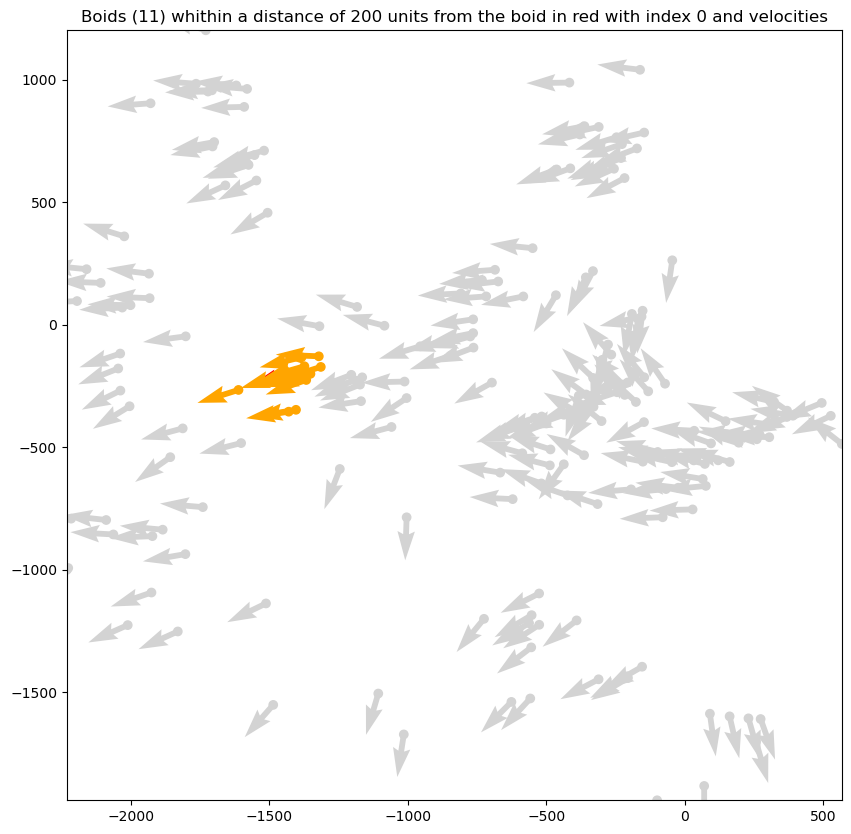

In [18]:
# test the function plot_neighbours_velocities
plot_neighbours_velocities(distances, 0, 200)

## Analysis of the differences between a 0-swarms and a 1-swarm

In [19]:
# choose at random two rows from df_merged which have Swarm_Behaviour = 0 and 1
swarm_0 = df_merged[df_merged['Swarm_Behaviour'] == 0].sample(n=1)
swarm_1 = df_merged[df_merged['Swarm_Behaviour'] == 1].sample(n=1)

In [20]:
# from each swarm extract two vectors x and y of all x_1,x_2,... and y_1,y_2,...
x_positions = ["x"+str(i) for i in range(1, 201)]
y_positions = ["y"+str(i) for i in range(1, 201)]
x_velocities = ["xVel"+str(i) for i in range(1, 201)]
y_velocities = ["yVel"+str(i) for i in range(1, 201)]
x_alignment = ["xA"+str(i) for i in range(1, 201)]
y_alignment = ["yA"+str(i) for i in range(1, 201)]
x_cohesion = ["xC"+str(i) for i in range(1, 201)]
y_cohesion = ["yC"+str(i) for i in range(1, 201)]
x_separation = ["xS"+str(i) for i in range(1, 201)]
y_separation = ["yS"+str(i) for i in range(1, 201)]
x_0 = swarm_0[x_positions]
y_0 = swarm_0[y_positions]
x_1 = swarm_1[x_positions]
y_1 = swarm_1[y_positions]
xVel_0 = swarm_0[x_velocities]
yVel_0 = swarm_0[y_velocities]
xVel_1 = swarm_1[x_velocities]
yVel_1 = swarm_1[y_velocities]
xA_0 = swarm_0[x_alignment]
yA_0 = swarm_0[y_alignment]
xA_1 = swarm_1[x_alignment]
yA_1 = swarm_1[y_alignment]
xC_0 = swarm_0[x_cohesion]
yC_0 = swarm_0[y_cohesion]
xC_1 = swarm_1[x_cohesion]
yC_1 = swarm_1[y_cohesion]
xS_0 = swarm_0[x_separation]
yS_0 = swarm_0[y_separation]
xS_1 = swarm_1[x_separation]
yS_1 = swarm_1[y_separation]

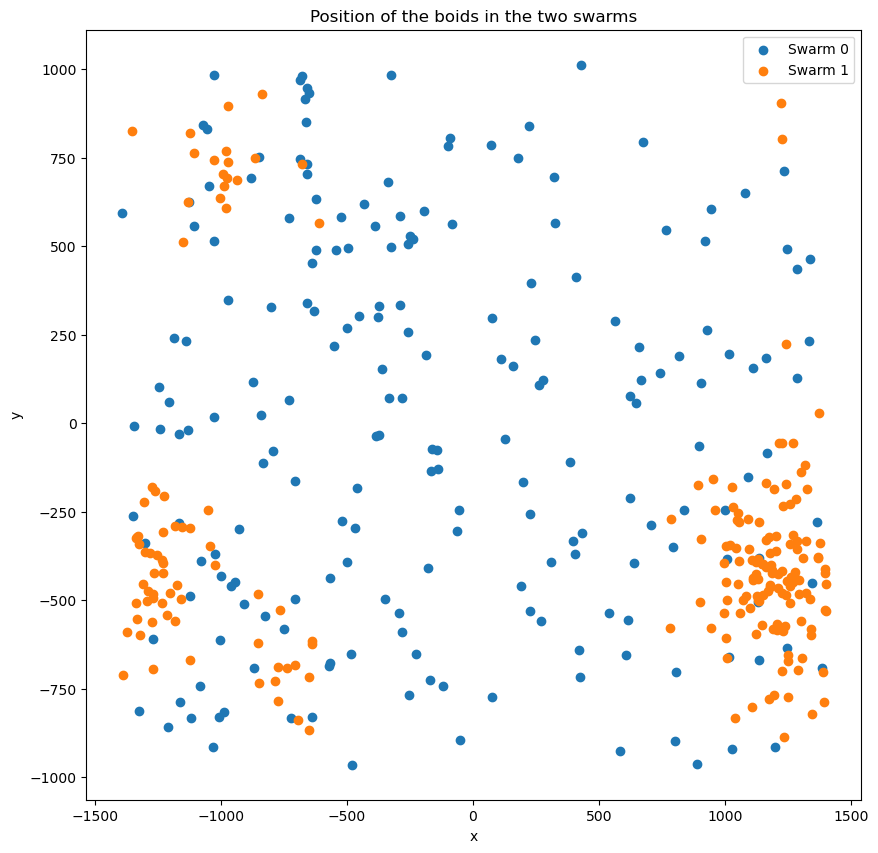

In [21]:
# plot the two swarms
plt.figure(figsize=(10, 10))
plt.scatter(x_0, y_0, label='Swarm 0')
plt.scatter(x_1, y_1, label='Swarm 1')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Position of the boids in the two swarms')
plt.legend()

/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


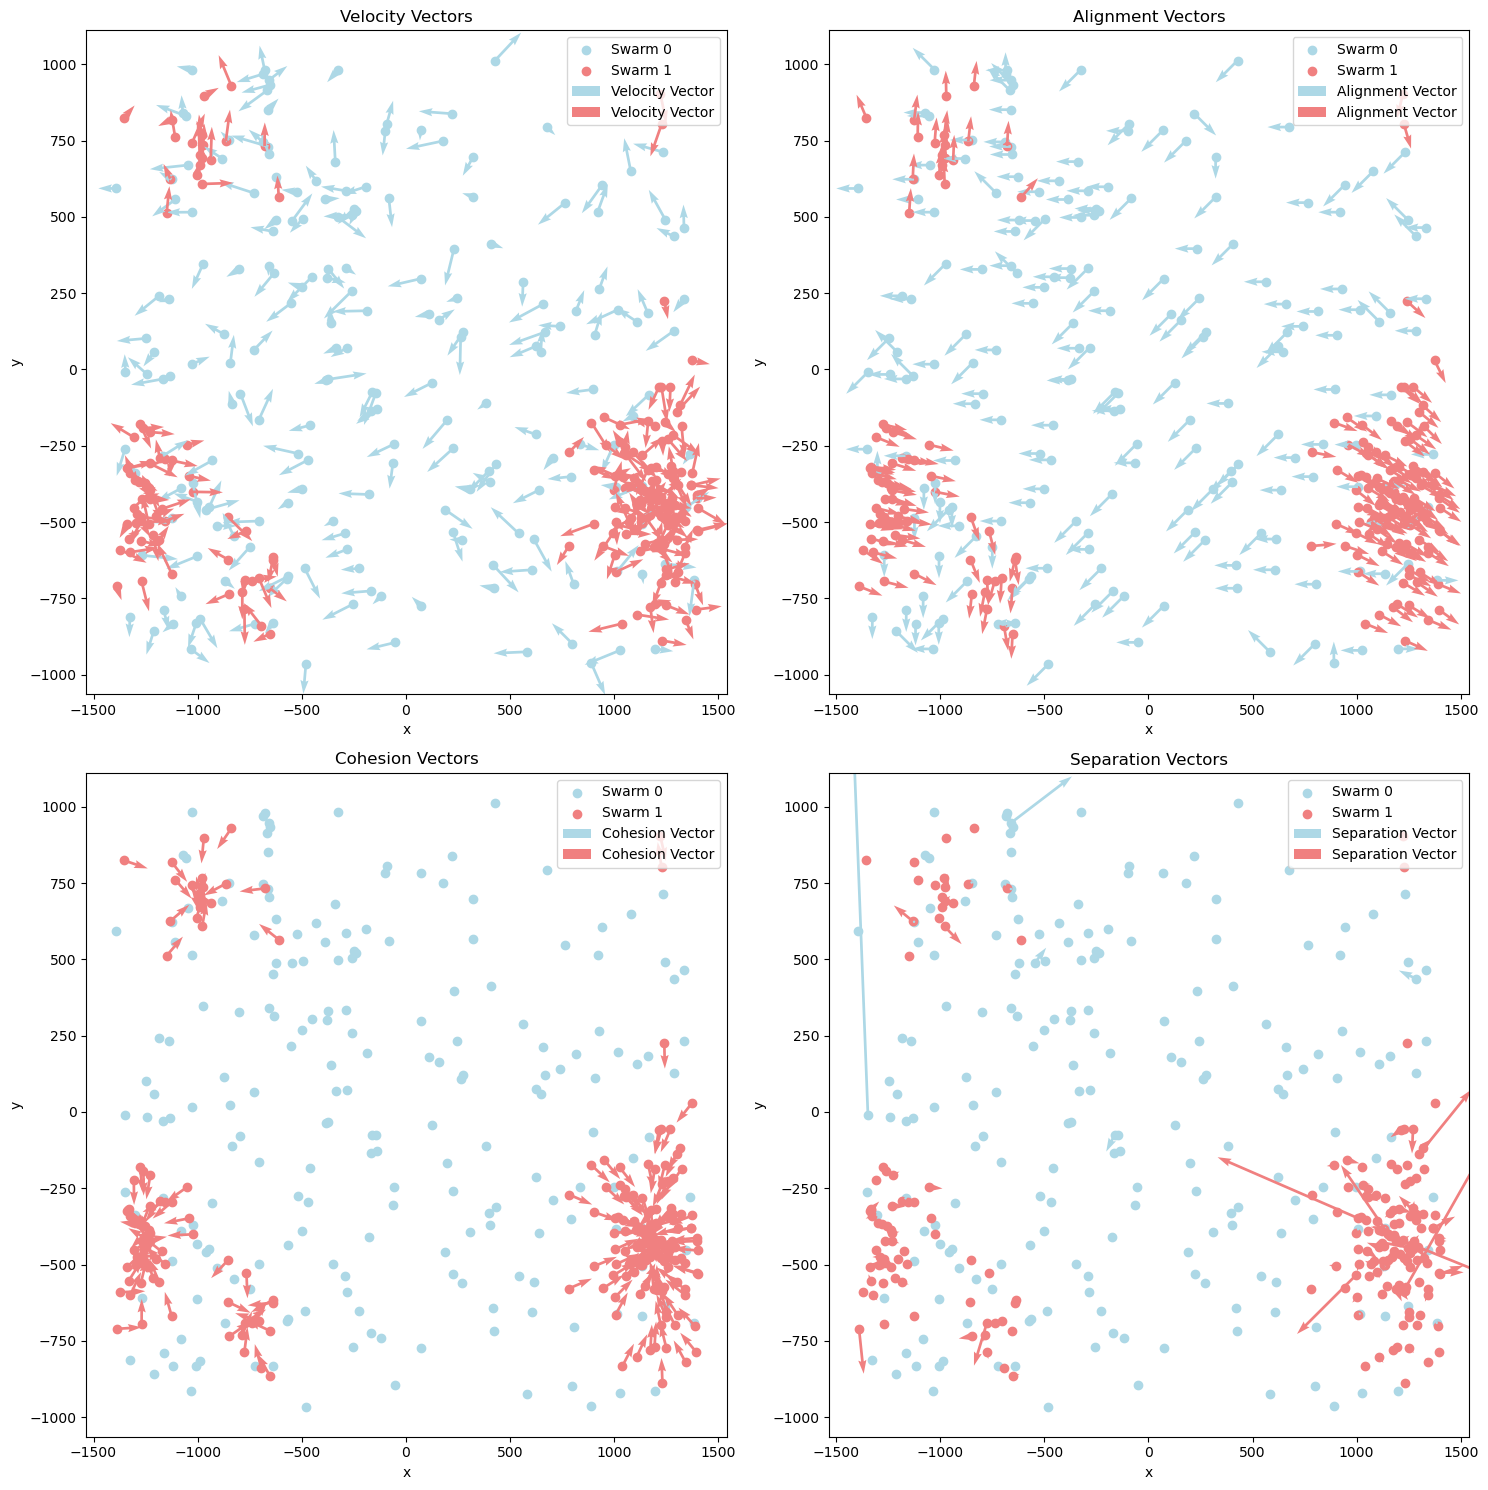

In [22]:
# Set up subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot for velocities
axs[0, 0].scatter(x_0, y_0, label='Swarm 0', color='lightblue')
axs[0, 0].scatter(x_1, y_1, label='Swarm 1', color='lightcoral')
axs[0, 0].quiver(x_0, y_0, xVel_0, yVel_0, color='lightblue', label='Velocity Vector')
axs[0, 0].quiver(x_1, y_1, xVel_1, yVel_1, color='lightcoral', label='Velocity Vector')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].set_title('Velocity Vectors')
axs[0, 0].legend()

# Plot for alignment
axs[0, 1].scatter(x_0, y_0, label='Swarm 0', color='lightblue')
axs[0, 1].scatter(x_1, y_1, label='Swarm 1', color='lightcoral')
axs[0, 1].quiver(x_0, y_0, xA_0, yA_0, color='lightblue', label='Alignment Vector')
axs[0, 1].quiver(x_1, y_1, xA_1, yA_1, color='lightcoral', label='Alignment Vector')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
axs[0, 1].set_title('Alignment Vectors')
axs[0, 1].legend()

# Plot for cohesion
axs[1, 0].scatter(x_0, y_0, label='Swarm 0', color='lightblue')
axs[1, 0].scatter(x_1, y_1, label='Swarm 1', color='lightcoral')
axs[1, 0].quiver(x_0, y_0, xC_0, yC_0, color='lightblue', label='Cohesion Vector')
axs[1, 0].quiver(x_1, y_1, xC_1, yC_1, color='lightcoral', label='Cohesion Vector')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
axs[1, 0].set_title('Cohesion Vectors')
axs[1, 0].legend()

# Plot for separation
axs[1, 1].scatter(x_0, y_0, label='Swarm 0', color='lightblue')
axs[1, 1].scatter(x_1, y_1, label='Swarm 1', color='lightcoral')
axs[1, 1].quiver(x_0, y_0, xS_0, yS_0, color='lightblue', label='Separation Vector')
axs[1, 1].quiver(x_1, y_1, xS_1, yS_1, color='lightcoral', label='Separation Vector')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
axs[1, 1].set_title('Separation Vectors')
axs[1, 1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()


## Train - Test split

In [23]:
# balance the dataset df_merged counting how many 0 and 1 there are and then taking the minimum between the two
# Count rows with 1
count_ones = len(df_merged[df_merged['Swarm_Behaviour'] == 1])

# Count rows with 0
count_zeros = len(df_merged[df_merged['Swarm_Behaviour'] == 0])

# Print the counts
print(f"Rows with 1: {count_ones}")
print(f"Rows with 0: {count_zeros}")

# take the minimum between the two
min_count = min(count_ones, count_zeros)

# Filter rows with 1
selected_df_ones = df_merged[df_merged['Swarm_Behaviour'] == 1].iloc[:min_count]

# Filter rows with 0
selected_df_zeros = df_merged[df_merged['Swarm_Behaviour'] == 0].iloc[:min_count]

# Concatenate the selected DataFrames
selected_df_merged = pd.concat([selected_df_ones, selected_df_zeros])

# Reset the index of the new DataFrame
selected_df_merged.reset_index(drop=True, inplace=True)

# Check if rows of selected_df_merged are contained in df
rows_contained = selected_df_merged.isin(df_merged.to_dict(orient='list')).all(axis=1)

# how many contained rows?
print("The number of contained rows is: ", len(selected_df_merged[rows_contained]), " over ", len(selected_df_merged), " (rows selected_df_merged contained in df_merged)")

df_merged = selected_df_merged

# print the number of 0 and 1 in the column Swarm_Behaviour of df_merged
print("The number of 0 in the column Swarm_Behaviour of df_merged is: ", len(df_merged[df_merged['Swarm_Behaviour'] == 0]))
print("The number of 1 in the column Swarm_Behaviour of df_merged is: ", len(df_merged[df_merged['Swarm_Behaviour'] == 1]))


Rows with 1: 7954
Rows with 0: 15355
The number of contained rows is:  15908  over  15908  (rows selected_df_merged contained in df_merged)
The number of 0 in the column Swarm_Behaviour of df_merged is:  7954
The number of 1 in the column Swarm_Behaviour of df_merged is:  7954


In [24]:
# split the dataset merged into train and test set
train, test = train_test_split(df_merged, test_size=0.15) #, random_state=42)

# dimensions of train and test set
print("The dimensions of train set is: ", train.shape)
print("The dimensions of test set is: ", test.shape)

X_train = train.drop('Swarm_Behaviour', axis=1)
y_train = train['Swarm_Behaviour']
X_test = test.drop('Swarm_Behaviour', axis=1)
y_test = test['Swarm_Behaviour']

The dimensions of train set is:  (13521, 2401)
The dimensions of test set is:  (2387, 2401)


In [25]:
# extract the column names of the features
features = X_train.columns
print(features)

Index(['x1', 'y1', 'xVel1', 'yVel1', 'xA1', 'yA1', 'xS1', 'yS1', 'xC1', 'yC1',
       ...
       'xVel200', 'yVel200', 'xA200', 'yA200', 'xS200', 'yS200', 'xC200',
       'yC200', 'nAC200', 'nS200'],
      dtype='object', length=2400)


# Baseline

## Linear Regression

In [26]:
# Rename the datasets
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Fit Simple Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print or use the predictions as needed
print(predictions)

# Summary
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Make predictions on the validation set
predictions = model.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error on Validation Set:", mse)

# Convert predictions to binary (e.g., using a threshold)
threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)

[ 0.01385696  1.03167028 -0.03529687 ...  0.00740934  0.98677835
  0.20465757]
Coefficients: [-8.50835111e-08  5.93670128e-06 -9.35576286e-04 ... -1.28688540e-02
 -9.14757838e-05 -2.25326015e-03]
Intercept: 0.1669830537555137
Mean Squared Error on Validation Set: 0.08436247295053378


In [27]:
# Calculate confusion matrix
conf_matrix = confusion_matrix_with_headers(y_test, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, binary_predictions)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, binary_predictions)
print("Recall:", recall)

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1026          166
Actual 1           82         1113
Accuracy: 0.8961038961038961
Precision: 0.8702111024237685
Recall: 0.9313807531380753


## Logistic Regression

In [28]:
# Rename the datasets
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Fit Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Print or use the predictions as needed
print(predictions)

# Summary
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Make predictions on the validation set
predictions = model.predict(X_test)

# Convert probabilities to binary predictions using a threshold
threshold = 0.5
binary_predictions = np.where(model.predict_proba(X_test)[:, 1] > threshold, 1, 0)

[0. 1. 0. ... 0. 1. 0.]
Coefficients: [[-2.17177586e-05 -7.23727768e-04 -1.20399356e-03 ...  2.94900224e-05
  -8.56146864e-04  1.61280397e-04]]
Intercept: [-0.00011224]


/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
# Calculate confusion matrix
conf_matrix = confusion_matrix_with_headers(y_test, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, binary_predictions)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, binary_predictions)
print("Recall:", recall)

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0         1041          151
Actual 1           80         1115
Accuracy: 0.9032258064516129
Precision: 0.8807266982622433
Recall: 0.9330543933054394


# Group Lasso

## Linear Group Lasso

### k-fold CV with Group Lasso - grouped by boid

In [54]:
# Define the number of folds
k_folds = 5  # You can choose the number of folds

# Define the groups for the features
groups = list(chain.from_iterable([[i] * 12 for i in range(200)])) # 200 groups of 12 features grouping by boid 

# Define a sequence of lambda values
lam_seq = np.linspace(1, 5 * 1000, num=40) / 10000

grp_lasso_iterations = 100

grp_lasso_tollerace = 1e-20

In [55]:
import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [56]:
# Create the k-fold cross-validation iterator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize an array to store the predictions on the test set
all_preds = np.zeros(len(X_train))

# Initialize arrays to store mean and standard deviation values
mean_values_deviance = []
sd_values_deviance = []

# Initialize arrays to store mean and standard deviation values
mean_values_mse = []
sd_values_mse = []

# Initialize arrays to store accuracy values
lam_accuracy_values = []

# Initialize lambda counter 
lam_counter = 0
lambda_total = len(lam_seq)

# Iterate through each lambda value in your sequence
for lam_value in lam_seq: 
    # print the lambda counter
    lam_counter += 1
    print("Lambda counter: ", lam_counter, " out of ", lambda_total)

    # Initialize an array to store deviance values for each fold
    deviance_values = []

    # Initialize an array to store the mse values for each fold
    mse_values = []

    # Initialize an array to store accuracy values for each fold
    accuracy_values = []

    # Initialize the fold counter
    fold_counter = 1

    # Iterate through each fold
    for train_index, val_index in kf.split(X_train):
        
        # save the starting time of the fold 
        time_start = time.time()

        # Print the fold number
        print("Start fold number ", fold_counter, " for lambda number ", lam_counter, " out of ", lambda_total)

        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Define the group lasso model for each fold with the specific lambda value
        grp_lasso_fold = GroupLasso(
            groups=groups,
            group_reg=lam_value,
            l1_reg = 0,
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size", 
            n_iter=grp_lasso_iterations,
            tol=grp_lasso_tollerace,
            supress_warning=True
        )

        # Fit the model on the training set
        grp_lasso_fold.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        fold_preds = grp_lasso_fold.predict(X_val_fold.values)

        # Calculate deviance for this fold
        deviance = -2 * np.sum(y_val_fold * np.log(fold_preds) + (1 - y_val_fold) * np.log(1 - fold_preds))
        deviance_values.append(deviance)

        # calculate the mse for this fold
        mse = np.mean((y_val_fold - fold_preds)**2)
        mse_values.append(mse)

        # Calculate accuracy for this fold
        pred = np.where(fold_preds > 0.5, 1, 0)
        accuracy = accuracy_score(y_val_fold, pred)
        accuracy_values.append(accuracy)
        # Print accuracy for this fold
        print("Accuracy for the fold number ", fold_counter, "is: {:.2%}".format(accuracy))
        
        # Print the time taken for each fold
        end_time = time.time()
        elapsed_time_seconds = end_time - time_start
        threshold_seconds = 60  # Set your threshold in seconds, for example, 60 seconds
        elapsed_time_minutes = elapsed_time_seconds / 60
        
        if elapsed_time_seconds < threshold_seconds:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_seconds, 2), "seconds")
        else:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_minutes, 2), "minutes")
        fold_counter += 1

        # if fold_counter and lam_counter 1 then print the estimated time
        if fold_counter == 2 and lam_counter == 1:
            print("----------------------------------------------------------------------")
            # print the hyperparameters
            print("Since the number of folds is ", k_folds, " and the number of lambda values is ", lambda_total, " the total number of fits is ", k_folds * lambda_total, "hence:")

            # print the estimated time in seconds
            print("The estimated total time is: ", round(elapsed_time_seconds * k_folds * lambda_total, 2), "seconds or ", round(elapsed_time_minutes * k_folds * lambda_total, 2), "minutes")
            
            # print eta on clock time
            current_time = datetime.datetime.now()
            eta_time = current_time + datetime.timedelta(seconds=elapsed_time_seconds * k_folds * lambda_total)
            print("ETA:", eta_time.strftime("%Y-%m-%d %H:%M:%S"))
        
        print("----------------------------------------------------------------------")
    
    # Calculate mean accuracy for this lambda value
    mean_accuracy = np.mean(accuracy_values)
    lam_accuracy_values.append(mean_accuracy)

    # Print mean accuracy for this lambda value
    print(f"Mean Accuracy for Lambda={lam_value}: {round(100*mean_accuracy,2)}%")

    print("----------------------------------------------------------------------")

    # Calculate mean and standard deviation for this lambda value for deviance
    mean_val = np.mean(deviance_values)
    sd_val = np.std(deviance_values)

    # Append to arrays
    mean_values_deviance.append(mean_val)
    sd_values_deviance.append(sd_val)

    # Calculate mean and standard deviation for this lambda value for mse
    mean_mse = np.mean(mse_values)
    sd_mse = np.std(mse_values)

    # Append to arrays
    mean_values_mse.append(mean_mse)
    sd_values_mse.append(sd_mse)


Lambda counter:  1  out of  40
Start fold number  1  for lambda number  1  out of  40
Accuracy for the fold number  1 is: 49.24%
The time taken for the fold number  1 is: 50.66 seconds
----------------------------------------------------------------------
Since the number of folds is  5  and the number of lambda values is  40  the total number of fits is  200 hence:
The estimated total time is:  10132.51 seconds or  168.88 minutes
ETA: 2023-12-28 18:51:22
----------------------------------------------------------------------
Start fold number  2  for lambda number  1  out of  40
Accuracy for the fold number  2 is: 50.48%
The time taken for the fold number  2 is: 55.88 seconds
----------------------------------------------------------------------
Start fold number  3  for lambda number  1  out of  40
Accuracy for the fold number  3 is: 51.22%
The time taken for the fold number  3 is: 57.45 seconds
----------------------------------------------------------------------
Start fold number  

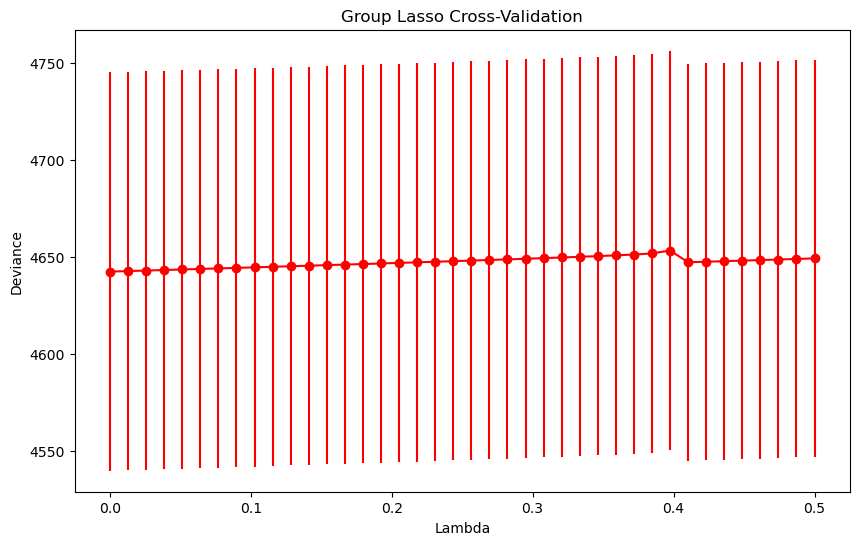

In [57]:
# Convert to NumPy arrays for plotting
mean_values_deviance = np.array(mean_values_deviance)
sd_values_deviance = np.array(sd_values_deviance)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_deviance, yerr=(sd_values_deviance / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Deviance")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

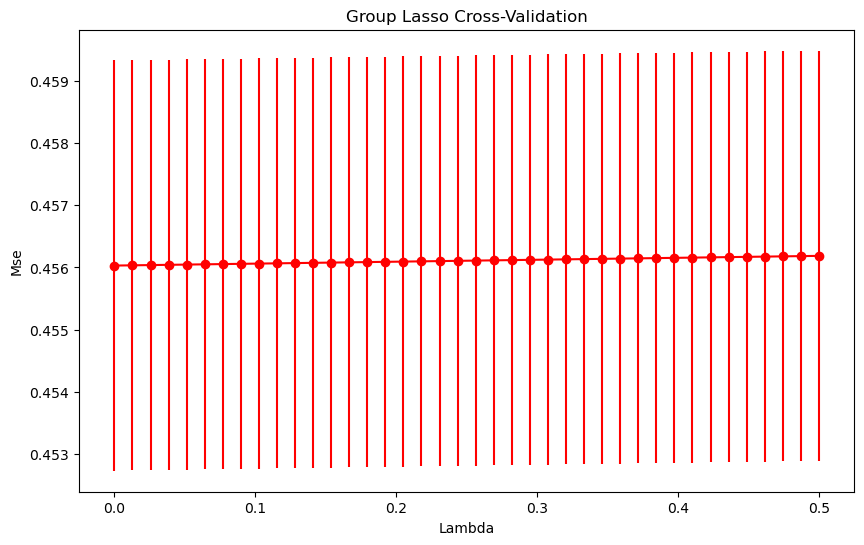

In [58]:
# Convert to NumPy arrays for plotting
mean_values_mse = np.array(mean_values_mse)
sd_values_mse = np.array(sd_values_mse)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_mse, yerr=(sd_values_mse / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Mse")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

In [59]:
mean_values_mse

array([0.45603018, 0.45603419, 0.45603819, 0.45604219, 0.45604619,
       0.4560502 , 0.4560542 , 0.4560582 , 0.45606221, 0.45606621,
       0.45607021, 0.45607422, 0.45607822, 0.45608223, 0.45608623,
       0.45609024, 0.45609424, 0.45609825, 0.45610225, 0.45610626,
       0.45611027, 0.45611427, 0.45611828, 0.45612229, 0.45612629,
       0.4561303 , 0.45613431, 0.45613832, 0.45614232, 0.45614633,
       0.45615034, 0.45615435, 0.45615836, 0.45616237, 0.45616638,
       0.45617039, 0.4561744 , 0.45617841, 0.45618242, 0.45618643])

In [60]:
# which is the lambda with the minimum mse?
min_mse = min(mean_values_mse)
min_mse_index = mean_values_mse.tolist().index(min_mse)

# print the lambda with the minimum mse
print("The lambda with the minimum mse is: ", lam_seq[min_mse_index])
print("The minimum mse is: ", min_mse)
print("It corresponds to the index: ", min_mse_index)

The lambda with the minimum mse is:  0.0001
The minimum mse is:  0.45603018313564503
It corresponds to the index:  0


### Group Lasso - grouped by boid - lambda: 0.0001

In [30]:
#implement group lasso on the train set

# define the groups for the features
groups = list(chain.from_iterable([[i] * 12 for i in range(200)])) # 200 groups of 12 features grouping by boid 

# define the group lasso model
grp_lasso = GroupLasso(
    groups=groups, # the groups for the features
    group_reg=0.0001, # the regularization parameter for the groups
    l1_reg=0, # the regularization parameter for the lasso penalty
    frobenius_lipschitz=True, # using the frobenius matrix norm
    scale_reg="inverse_group_size", # scaling the regularization parameter by the size of the groups
    n_iter = 2000, # number of iterations
    tol=1e-20, # tolerance for the stopping condition
)

# fit the group lasso model on the train set
grp_lasso.fit(X_train, y_train)

# predict the labels on the test set
pred = grp_lasso.predict(X_test)

/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/group_lasso/_group_lasso.py:457: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)
/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


In [31]:
# tranform pred into binary
pred = np.where(pred>0.5, 1, 0)

# calculate the accuracy score
accuracy = accuracy_score(y_test, pred)

# print the accuracy score
print("The accuracy score is: ", accuracy)

# print the precision score
print("The precision score is: ", precision_score(y_test, pred))

# print the recall score
print("The recall score is: ", recall_score(y_test, pred))

# print the coefficients of the model
print("The coefficients of the model are: ", grp_lasso.coef_)

# print the intercept of the model
print("The intercept of the model is: ", grp_lasso.intercept_)

# print the groups of the model
print("The groups of the model are: ", grp_lasso.groups_)

# print the confusion matrix
print("The confusion matrix is: ")
print(confusion_matrix_with_headers(y_test, pred))

The accuracy score is:  0.6217008797653959
The precision score is:  0.9894736842105263
The recall score is:  0.23857868020304568
The coefficients of the model are:  [[-1.93649083e-05]
 [-3.69129877e-05]
 [-4.53697673e-06]
 ...
 [ 1.10292361e-07]
 [ 2.92649450e-06]
 [ 1.28490975e-06]]
The intercept of the model is:  [-0.25152586]
The groups of the model are:  [array([ True,  True,  True, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, F

### k-fold CV with Group Lasso - grouped by same measuere

In [61]:
# Define the number of folds
k_folds = 5  # You can choose the number of folds

# Define the groups for the features
groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] * 200

# Define a sequence of lambda values
lam_seq = np.linspace(1, 5 * 1000, num=40) / 10000

grp_lasso_iterations = 100

grp_lasso_tollerace = 1e-20

In [62]:
import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [63]:
# Create the k-fold cross-validation iterator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize an array to store the predictions on the test set
all_preds = np.zeros(len(X_train))

# Initialize arrays to store mean and standard deviation values
mean_values_deviance = []
sd_values_deviance = []

# Initialize arrays to store mean and standard deviation values
mean_values_mse = []
sd_values_mse = []

# Initialize arrays to store accuracy values
lam_accuracy_values = []

# Initialize lambda counter 
lam_counter = 0
lambda_total = len(lam_seq)

# Iterate through each lambda value in your sequence
for lam_value in lam_seq: 
    # print the lambda counter
    lam_counter += 1
    print("Lambda counter: ", lam_counter, " out of ", lambda_total)

    # Initialize an array to store deviance values for each fold
    deviance_values = []

    # Initialize an array to store the mse values for each fold
    mse_values = []

    # Initialize an array to store accuracy values for each fold
    accuracy_values = []

    # Initialize the fold counter
    fold_counter = 1

    # Iterate through each fold
    for train_index, val_index in kf.split(X_train):
        
        # save the starting time of the fold 
        time_start = time.time()

        # Print the fold number
        print("Start fold number ", fold_counter, " for lambda number ", lam_counter, " out of ", lambda_total)

        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Define the group lasso model for each fold with the specific lambda value
        grp_lasso_fold = GroupLasso(
            groups=groups,
            group_reg=lam_value,
            l1_reg = 0,
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size", 
            n_iter=grp_lasso_iterations,
            tol=grp_lasso_tollerace,
            supress_warning=True
        )

        # Fit the model on the training set
        grp_lasso_fold.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        fold_preds = grp_lasso_fold.predict(X_val_fold.values)

        # Calculate deviance for this fold
        deviance = -2 * np.sum(y_val_fold * np.log(fold_preds) + (1 - y_val_fold) * np.log(1 - fold_preds))
        deviance_values.append(deviance)

        # calculate the mse for this fold
        mse = np.mean((y_val_fold - fold_preds)**2)
        mse_values.append(mse)

        # Calculate accuracy for this fold
        pred = np.where(fold_preds > 0.5, 1, 0)
        accuracy = accuracy_score(y_val_fold, pred)
        accuracy_values.append(accuracy)
        # Print accuracy for this fold
        print("Accuracy for the fold number ", fold_counter, "is: {:.2%}".format(accuracy))
        
        # Print the time taken for each fold
        end_time = time.time()
        elapsed_time_seconds = end_time - time_start
        threshold_seconds = 60  # Set your threshold in seconds, for example, 60 seconds
        elapsed_time_minutes = elapsed_time_seconds / 60
        
        if elapsed_time_seconds < threshold_seconds:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_seconds, 2), "seconds")
        else:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_minutes, 2), "minutes")
        fold_counter += 1

        # if fold_counter and lam_counter 1 then print the estimated time
        if fold_counter == 2 and lam_counter == 1:
            print("----------------------------------------------------------------------")
            # print the hyperparameters
            print("Since the number of folds is ", k_folds, " and the number of lambda values is ", lambda_total, " the total number of fits is ", k_folds * lambda_total, "hence:")

            # print the estimated time in seconds
            print("The estimated total time is: ", round(elapsed_time_seconds * k_folds * lambda_total, 2), "seconds or ", round(elapsed_time_minutes * k_folds * lambda_total, 2), "minutes")
            
            # print eta on clock time
            current_time = datetime.datetime.now()
            eta_time = current_time + datetime.timedelta(seconds=elapsed_time_seconds * k_folds * lambda_total)
            print("ETA:", eta_time.strftime("%Y-%m-%d %H:%M:%S"))
        
        print("----------------------------------------------------------------------")
    
    # Calculate mean accuracy for this lambda value
    mean_accuracy = np.mean(accuracy_values)
    lam_accuracy_values.append(mean_accuracy)

    # Print mean accuracy for this lambda value
    print(f"Mean Accuracy for Lambda={lam_value}: {round(100*mean_accuracy,2)}%")

    print("----------------------------------------------------------------------")

    # Calculate mean and standard deviation for this lambda value for deviance
    mean_val = np.mean(deviance_values)
    sd_val = np.std(deviance_values)

    # Append to arrays
    mean_values_deviance.append(mean_val)
    sd_values_deviance.append(sd_val)

    # Calculate mean and standard deviation for this lambda value for mse
    mean_mse = np.mean(mse_values)
    sd_mse = np.std(mse_values)

    # Append to arrays
    mean_values_mse.append(mean_mse)
    sd_values_mse.append(sd_mse)


Lambda counter:  1  out of  40
Start fold number  1  for lambda number  1  out of  40
Accuracy for the fold number  1 is: 49.24%
The time taken for the fold number  1 is: 51.39 seconds
----------------------------------------------------------------------
Since the number of folds is  5  and the number of lambda values is  40  the total number of fits is  200 hence:
The estimated total time is:  10277.23 seconds or  171.29 minutes
ETA: 2023-12-28 21:54:33
----------------------------------------------------------------------
Start fold number  2  for lambda number  1  out of  40
Accuracy for the fold number  2 is: 50.48%
The time taken for the fold number  2 is: 56.32 seconds
----------------------------------------------------------------------
Start fold number  3  for lambda number  1  out of  40
Accuracy for the fold number  3 is: 51.22%
The time taken for the fold number  3 is: 56.41 seconds
----------------------------------------------------------------------
Start fold number  

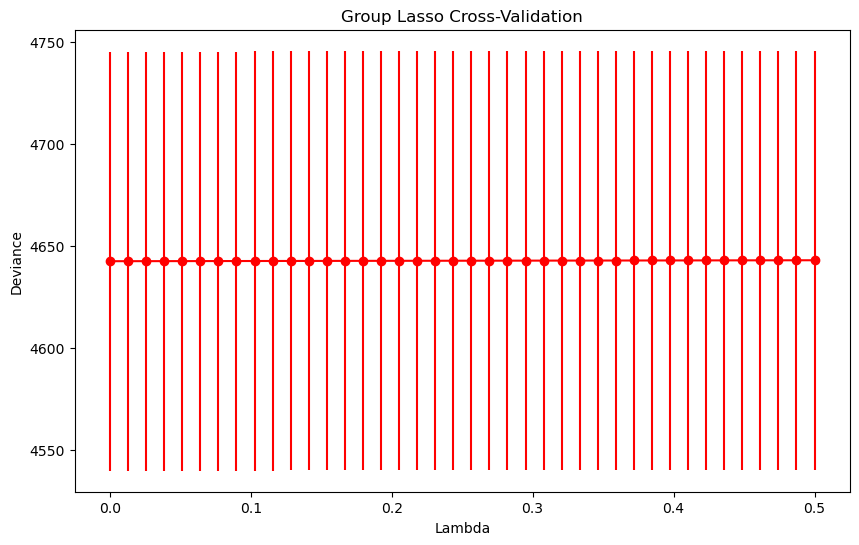

In [64]:
# Convert to NumPy arrays for plotting
mean_values_deviance = np.array(mean_values_deviance)
sd_values_deviance = np.array(sd_values_deviance)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_deviance, yerr=(sd_values_deviance / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Deviance")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

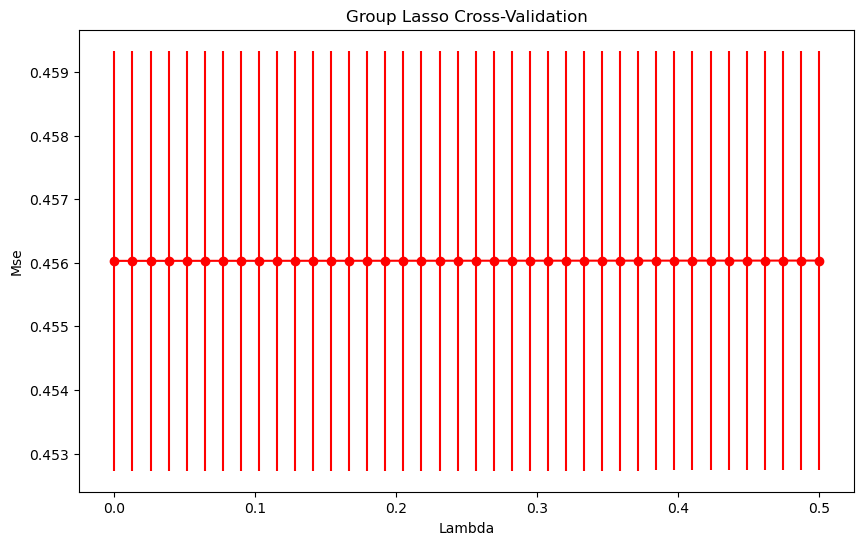

In [65]:
# Convert to NumPy arrays for plotting
mean_values_mse = np.array(mean_values_mse)
sd_values_mse = np.array(sd_values_mse)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_mse, yerr=(sd_values_mse / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Mse")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

In [66]:
mean_values_mse

array([0.45603015, 0.45603027, 0.45603039, 0.45603051, 0.45603063,
       0.45603075, 0.45603087, 0.45603099, 0.45603112, 0.45603124,
       0.45603136, 0.45603148, 0.4560316 , 0.45603172, 0.45603184,
       0.45603196, 0.45603208, 0.4560322 , 0.45603232, 0.45603244,
       0.45603256, 0.45603268, 0.4560328 , 0.45603292, 0.45603304,
       0.45603316, 0.45603328, 0.4560334 , 0.45603352, 0.45603364,
       0.45603376, 0.45603388, 0.456034  , 0.45603412, 0.45603424,
       0.45603436, 0.45603448, 0.4560346 , 0.45603472, 0.45603484])

In [67]:
# which is the lambda with the minimum mse?
min_mse = min(mean_values_mse)
min_mse_index = mean_values_mse.tolist().index(min_mse)

# print the lambda with the minimum mse
print("The lambda with the minimum mse is: ", lam_seq[min_mse_index])
print("The minimum mse is: ", min_mse)
print("It corresponds to the index: ", min_mse_index)

The lambda with the minimum mse is:  0.0001
The minimum mse is:  0.4560301528526446
It corresponds to the index:  0


### Group Lasso - grouped by same measure - lambda: 0.0001

In [30]:
#implement group lasso on the train set

# define the groups for the features
groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] * 200

# define the group lasso model
grp_lasso = GroupLasso(
    groups=groups, # the groups for the features
    group_reg=0.0001, # the regularization parameter for the groups
    l1_reg=0, # the regularization parameter for the lasso penalty
    frobenius_lipschitz=True, # using the frobenius matrix norm
    scale_reg="inverse_group_size", # scaling the regularization parameter by the size of the groups
    n_iter = 2000, # number of iterations
    tol=1e-20, # tolerance for the stopping condition
)

# fit the group lasso model on the train set
grp_lasso.fit(X_train, y_train)

# predict the labels on the test set
pred = grp_lasso.predict(X_test)

/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/group_lasso/_group_lasso.py:457: UserWarning: 
The behaviour has changed since v1.1.1, before then, a bug in the optimisation
algorithm made it so the regularisation parameter was scaled by the largest
eigenvalue of the covariance matrix.

To use the old behaviour, initialise the class with the keyword argument
`old_regularisation=True`.

To supress this warning, initialise the class with the keyword argument
`supress_warning=True`

  warnings.warn(_OLD_REG_WARNING)


In [ ]:
# tranform pred into binary
pred = np.where(pred>0.5, 1, 0)

# calculate the accuracy score
accuracy = accuracy_score(y_test, pred)

# print the accuracy score
print("The accuracy score is: ", accuracy)

# print the precision score
print("The precision score is: ", precision_score(y_test, pred))

# print the recall score
print("The recall score is: ", recall_score(y_test, pred))

# print the coefficients of the model
print("The coefficients of the model are: ", grp_lasso.coef_)

# print the intercept of the model
print("The intercept of the model is: ", grp_lasso.intercept_)

# print the groups of the model
print("The groups of the model are: ", grp_lasso.groups_)

# print the confusion matrix with headers
print("The confusion matrix is: ")
print(confusion_matrix_with_headers(y_test, pred))

The accuracy score is:  0.6145789694176791
The coefficients of the model are:  [[-1.39521971e-05]
 [-3.41932888e-05]
 [-4.74829032e-06]
 ...
 [ 1.15361809e-07]
 [ 2.84442333e-06]
 [ 1.50423832e-06]]
The intercept of the model is:  [-0.25517908]
The groups of the model are:  [array([ True, False, False, ..., False, False, False]), array([False,  True, False, ..., False, False, False]), array([False, False,  True, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ..., False, False, False]), array([False, False, False, ...,  True, False, False]), array([False, False, False, ..., False,  True, False]), array([False, False, False, ..., False, False,  True])]
The confusion matrix is: 
          Predicted 0  Pre

## Logistic Group Lasso

### k-fold CV with Logistic Group Lasso - grouped by boid

In [85]:
# Define the number of folds
k_folds = 5  # You can choose the number of folds

# Define the groups for the features
groups = list(chain.from_iterable([[i] * 12 for i in range(200)])) # 200 groups of 12 features grouping by boid 

# Define a sequence of lambda values
lam_seq = np.linspace(1, 5 * 1000, num=40) / 10000

grp_lasso_iterations = 100

grp_lasso_tollerace = 1e-20

In [86]:
import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [87]:
# Create the k-fold cross-validation iterator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize an array to store the predictions on the test set
all_preds = np.zeros(len(X_train))

# Initialize arrays to store mean and standard deviation values
mean_values_deviance = []
sd_values_deviance = []

# Initialize arrays to store mean and standard deviation values
mean_values_mse = []
sd_values_mse = []

# Initialize arrays to store accuracy values
lam_accuracy_values = []

# Initialize lambda counter 
lam_counter = 0
lambda_total = len(lam_seq)

# Iterate through each lambda value in your sequence
for lam_value in lam_seq: 
    # print the lambda counter
    lam_counter += 1
    print("Lambda counter: ", lam_counter, " out of ", lambda_total)

    # Initialize an array to store deviance values for each fold
    deviance_values = []

    # Initialize an array to store the mse values for each fold
    mse_values = []

    # Initialize an array to store accuracy values for each fold
    accuracy_values = []

    # Initialize the fold counter
    fold_counter = 1

    # Iterate through each fold
    for train_index, val_index in kf.split(X_train):
        
        # save the starting time of the fold 
        time_start = time.time()

        # Print the fold number
        print("Start fold number ", fold_counter, " for lambda number ", lam_counter, " out of ", lambda_total)

        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Define the group lasso model for each fold with the specific lambda value
        grp_lasso_fold = LogisticGroupLasso(
            groups=groups,
            group_reg=lam_value,
            l1_reg=0,
            scale_reg="inverse_group_size",
            n_iter=grp_lasso_iterations,
            tol=grp_lasso_tollerace,
            supress_warning=True
        )

        # Fit the model on the training set
        grp_lasso_fold.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        fold_preds = grp_lasso_fold.predict_proba(X_val_fold.values)[:, 1]

        # Calculate deviance for this fold
        deviance = -2 * np.sum(y_val_fold * np.log(fold_preds) + (1 - y_val_fold) * np.log(1 - fold_preds))
        deviance_values.append(deviance)

        # calculate the mse for this fold
        mse = np.mean((y_val_fold - fold_preds)**2)
        mse_values.append(mse)

        # Calculate accuracy for this fold
        pred = np.where(fold_preds>0.5, 1, 0)
        accuracy = accuracy_score(y_val_fold, pred)
        accuracy_values.append(accuracy)
        # Print accuracy for this fold
        print("Accuracy for the fold number ", fold_counter, "is: {:.2%}".format(accuracy))
        
        # Print the time taken for each fold
        end_time = time.time()
        elapsed_time_seconds = end_time - time_start
        threshold_seconds = 60  # Set your threshold in seconds, for example, 60 seconds
        elapsed_time_minutes = elapsed_time_seconds / 60
        
        if elapsed_time_seconds < threshold_seconds:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_seconds, 2), "seconds")
        else:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_minutes, 2), "minutes")
        fold_counter += 1

        # if fold_counter and lam_counter 1 then print the estimated time
        if fold_counter == 2 and lam_counter == 1:
            print("----------------------------------------------------------------------")
            # print the hyperparameters
            print("Since the number of folds is ", k_folds, " and the number of lambda values is ", lambda_total, " the total number of fits is ", k_folds * lambda_total, "hence:")

            # print the estimated time in seconds
            print("The estimated total time is: ", round(elapsed_time_seconds * k_folds * lambda_total, 2), "seconds or ", round(elapsed_time_minutes * k_folds * lambda_total, 2), "minutes")
            
            # print eta on clock time
            current_time = datetime.datetime.now()
            eta_time = current_time + datetime.timedelta(seconds=elapsed_time_seconds * k_folds * lambda_total)
            print("ETA:", eta_time.strftime("%Y-%m-%d %H:%M:%S"))
        
        print("----------------------------------------------------------------------")
    
    # Calculate mean accuracy for this lambda value
    mean_accuracy = np.mean(accuracy_values)
    lam_accuracy_values.append(mean_accuracy)

    # Print mean accuracy for this lambda value
    print(f"Mean Accuracy for Lambda={lam_value}: {round(100*mean_accuracy,2)}%")

    print("----------------------------------------------------------------------")

    # Calculate mean and standard deviation for this lambda value for deviance
    mean_val = np.mean(deviance_values)
    sd_val = np.std(deviance_values)

    # Append to arrays
    mean_values_deviance.append(mean_val)
    sd_values_deviance.append(sd_val)

    # Calculate mean and standard deviation for this lambda value for mse
    mean_mse = np.mean(mse_values)
    sd_mse = np.std(mse_values)

    # Append to arrays
    mean_values_mse.append(mean_mse)
    sd_values_mse.append(sd_mse)

Lambda counter:  1  out of  40
Start fold number  1  for lambda number  1  out of  40
Accuracy for the fold number  1 is: 78.63%
The time taken for the fold number  1 is: 1.07 minutes
----------------------------------------------------------------------
Since the number of folds is  5  and the number of lambda values is  40  the total number of fits is  200 hence:
The estimated total time is:  12843.76 seconds or  214.06 minutes
ETA: 2023-12-28 05:45:00
----------------------------------------------------------------------
Start fold number  2  for lambda number  1  out of  40
Accuracy for the fold number  2 is: 78.29%
The time taken for the fold number  2 is: 1.23 minutes
----------------------------------------------------------------------
Start fold number  3  for lambda number  1  out of  40
Accuracy for the fold number  3 is: 78.00%
The time taken for the fold number  3 is: 1.16 minutes
----------------------------------------------------------------------
Start fold number  4  

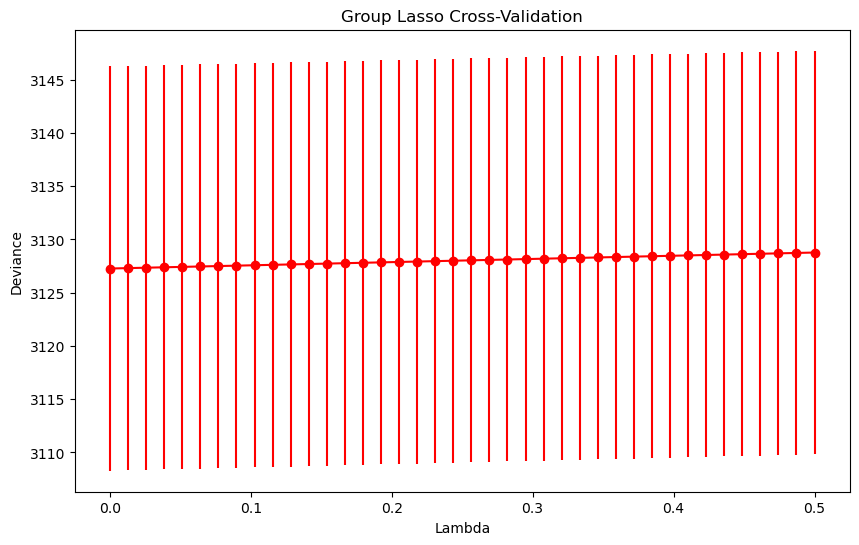

In [88]:
# Convert to NumPy arrays for plotting
mean_values_deviance = np.array(mean_values_deviance)
sd_values_deviance = np.array(sd_values_deviance)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_deviance, yerr=(sd_values_deviance / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Deviance")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

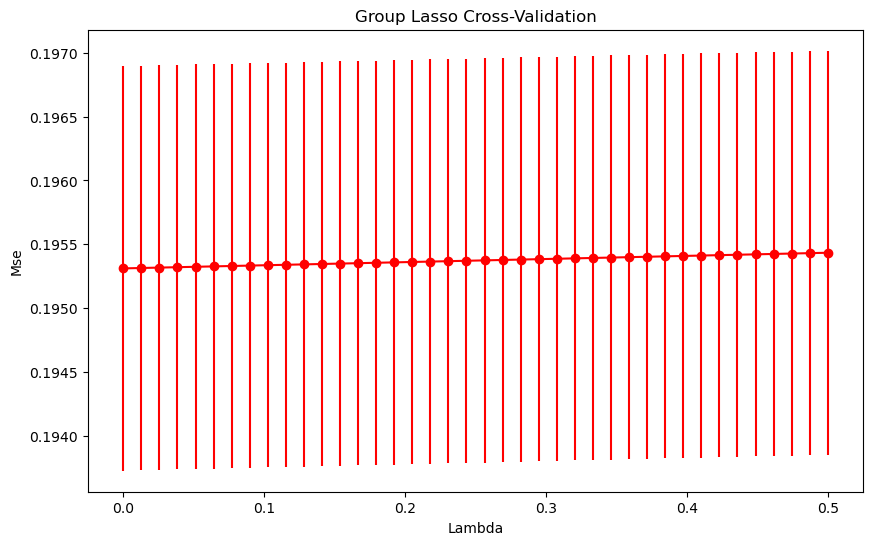

In [89]:
# Convert to NumPy arrays for plotting
mean_values_mse = np.array(mean_values_mse)
sd_values_mse = np.array(sd_values_mse)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_mse, yerr=(sd_values_mse / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Mse")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

In [90]:
mean_values_mse

array([0.1953119 , 0.19531504, 0.19531818, 0.19532132, 0.19532445,
       0.19532759, 0.19533073, 0.19533387, 0.19533701, 0.19534015,
       0.19534329, 0.19534643, 0.19534957, 0.19535271, 0.19535585,
       0.195359  , 0.19536214, 0.19536528, 0.19536842, 0.19537156,
       0.1953747 , 0.19537785, 0.19538099, 0.19538413, 0.19538727,
       0.19539042, 0.19539356, 0.1953967 , 0.19539985, 0.19540299,
       0.19540613, 0.19540928, 0.19541242, 0.19541557, 0.19541871,
       0.19542186, 0.195425  , 0.19542815, 0.19543129, 0.19543444])

In [91]:
# which is the lambda with the minimum mse?
min_mse = min(mean_values_mse)
min_mse_index = mean_values_mse.tolist().index(min_mse)

# print the lambda with the minimum mse
print("The lambda with the minimum mse is: ", lam_seq[min_mse_index])
print("The minimum mse is: ", min_mse)
print("It corresponds to the index: ", min_mse_index)

The lambda with the minimum mse is:  0.0001
The minimum mse is:  0.19531189963011025
It corresponds to the index:  0


### Logistic Group Lasso - grouped by boid - lambda: 0.0001

In [ ]:
#implement group lasso on the train set

# define the groups for the features
groups = list(chain.from_iterable([[i] * 12 for i in range(200)])) # 200 groups of 12 features grouping by boid 

# lambda with the minimum mse
lam_value = 0.0001

# define the group lasso model
grp_lasso = LogisticGroupLasso(
    groups=groups, # the groups for the features
    group_reg=lam_value, # the regularization parameter for the groups
    l1_reg=0, # the regularization parameter for the lasso penalty
    scale_reg="inverse_group_size", # scaling the regularization parameter by the size of the groups
    n_iter = 2000, # number of iterations
    tol=1e-20, # tolerance for the stopping condition
)

# fit the group lasso model on the train set
grp_lasso.fit(X_train, y_train)

# predict probabilities
pred = grp_lasso.predict_proba(X_test.values)[:, 1]

In [ ]:
# tranform pred into binary
pred = np.where(pred>0.5, 1, 0)

# calculate the accuracy score
accuracy = accuracy_score(y_test, pred)

# print the accuracy score
print("The accuracy score is: ", accuracy)

# print the precision score
print("The precision score is: ", precision_score(y_test, pred))

# print the recall score
print("The recall score is: ", recall_score(y_test, pred))

# print the coefficients of the model
print("The coefficients of the model are: ", grp_lasso.coef_[:, 1])

# print the intercept of the model
print("The intercept of the model is: ", grp_lasso.intercept_[1])

# print the groups of the model
print("The groups of the model are: ", grp_lasso.groups_[1])

# print the confusion matrix with headers
print("The confusion matrix is: ")
print(confusion_matrix_with_headers(y_test, pred))

The accuracy score is:  0.9103477167993297
The coefficients of the model are:  [-1.25326073e-04 -1.20480073e-04 -1.31071558e-05 ...  2.07008183e-07
  1.85448220e-06  2.86783166e-06]
The intercept of the model is:  -1.2662338425791309
The groups of the model are:  [False False False ... False False False]
The confusion matrix is: 
          Predicted 0  Predicted 1
Actual 0          991          155
Actual 1           59         1182


### k-fold CV with Logistic Group Lasso - grouped by same measure

In [77]:
# Define the number of folds
k_folds = 5  # You can choose the number of folds

# Define the groups for the features
groups = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] * 200

# Define a sequence of lambda values
lam_seq = np.linspace(1, 5 * 1000, num=40) / 10000

grp_lasso_iterations = 100

grp_lasso_tollerace = 1e-20

In [78]:
import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [79]:
# Create the k-fold cross-validation iterator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize an array to store the predictions on the test set
all_preds = np.zeros(len(X_train))

# Initialize arrays to store mean and standard deviation values
mean_values_deviance = []
sd_values_deviance = []

# Initialize arrays to store mean and standard deviation values
mean_values_mse = []
sd_values_mse = []

# Initialize arrays to store accuracy values
lam_accuracy_values = []

# Initialize lambda counter 
lam_counter = 0
lambda_total = len(lam_seq)

# Iterate through each lambda value in your sequence
for lam_value in lam_seq: 
    # print the lambda counter
    lam_counter += 1
    print("Lambda counter: ", lam_counter, " out of ", lambda_total)

    # Initialize an array to store deviance values for each fold
    deviance_values = []

    # Initialize an array to store the mse values for each fold
    mse_values = []

    # Initialize an array to store accuracy values for each fold
    accuracy_values = []

    # Initialize the fold counter
    fold_counter = 1

    # Iterate through each fold
    for train_index, val_index in kf.split(X_train):
        
        # save the starting time of the fold 
        time_start = time.time()

        # Print the fold number
        print("Start fold number ", fold_counter, " for lambda number ", lam_counter, " out of ", lambda_total)

        # Split the data into training and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Define the group lasso model for each fold with the specific lambda value
        grp_lasso_fold = LogisticGroupLasso(
            groups=groups,
            group_reg=lam_value,
            l1_reg=0,
            scale_reg="inverse_group_size",
            n_iter=grp_lasso_iterations,
            tol=grp_lasso_tollerace,
            supress_warning=True
        )

        # Fit the model on the training set
        grp_lasso_fold.fit(X_train_fold, y_train_fold)

        # Predict on the validation set
        fold_preds = grp_lasso_fold.predict_proba(X_val_fold.values)[:, 1]

        # Calculate deviance for this fold
        deviance = -2 * np.sum(y_val_fold * np.log(fold_preds) + (1 - y_val_fold) * np.log(1 - fold_preds))
        deviance_values.append(deviance)

        # calculate the mse for this fold
        mse = np.mean((y_val_fold - fold_preds)**2)
        mse_values.append(mse)

        # Calculate accuracy for this fold
        pred = np.where(fold_preds>0.5, 1, 0)
        accuracy = accuracy_score(y_val_fold, pred)
        accuracy_values.append(accuracy)
        # Print accuracy for this fold
        print("Accuracy for the fold number ", fold_counter, "is: {:.2%}".format(accuracy))
        
        # Print the time taken for each fold
        end_time = time.time()
        elapsed_time_seconds = end_time - time_start
        threshold_seconds = 60  # Set your threshold in seconds, for example, 60 seconds
        elapsed_time_minutes = elapsed_time_seconds / 60
        
        if elapsed_time_seconds < threshold_seconds:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_seconds, 2), "seconds")
        else:
            print("The time taken for the fold number ", fold_counter, "is:", round(elapsed_time_minutes, 2), "minutes")
        fold_counter += 1

        # if fold_counter and lam_counter 1 then print the estimated time
        if fold_counter == 2 and lam_counter == 1:
            print("----------------------------------------------------------------------")
            # print the hyperparameters
            print("Since the number of folds is ", k_folds, " and the number of lambda values is ", lambda_total, " the total number of fits is ", k_folds * lambda_total, "hence:")

            # print the estimated time in seconds
            print("The estimated total time is: ", round(elapsed_time_seconds * k_folds * lambda_total, 2), "seconds or ", round(elapsed_time_minutes * k_folds * lambda_total, 2), "minutes")
            
            # print eta on clock time
            current_time = datetime.datetime.now()
            eta_time = current_time + datetime.timedelta(seconds=elapsed_time_seconds * k_folds * lambda_total)
            print("ETA:", eta_time.strftime("%Y-%m-%d %H:%M:%S"))
        
        print("----------------------------------------------------------------------")
    
    # Calculate mean accuracy for this lambda value
    mean_accuracy = np.mean(accuracy_values)
    lam_accuracy_values.append(mean_accuracy)

    # Print mean accuracy for this lambda value
    print(f"Mean Accuracy for Lambda={lam_value}: {round(100*mean_accuracy,2)}%")

    print("----------------------------------------------------------------------")

    # Calculate mean and standard deviation for this lambda value for deviance
    mean_val = np.mean(deviance_values)
    sd_val = np.std(deviance_values)

    # Append to arrays
    mean_values_deviance.append(mean_val)
    sd_values_deviance.append(sd_val)

    # Calculate mean and standard deviation for this lambda value for mse
    mean_mse = np.mean(mse_values)
    sd_mse = np.std(mse_values)

    # Append to arrays
    mean_values_mse.append(mean_mse)
    sd_values_mse.append(sd_mse)

Lambda counter:  1  out of  40
Start fold number  1  for lambda number  1  out of  40
Accuracy for the fold number  1 is: 78.63%
The time taken for the fold number  1 is: 1.04 minutes
----------------------------------------------------------------------
Since the number of folds is  5  and the number of lambda values is  40  the total number of fits is  200 hence:
The estimated total time is:  12448.61 seconds or  207.48 minutes
ETA: 2023-12-27 19:53:34
----------------------------------------------------------------------
Start fold number  2  for lambda number  1  out of  40
Accuracy for the fold number  2 is: 78.29%
The time taken for the fold number  2 is: 1.07 minutes
----------------------------------------------------------------------
Start fold number  3  for lambda number  1  out of  40
Accuracy for the fold number  3 is: 78.00%
The time taken for the fold number  3 is: 1.07 minutes
----------------------------------------------------------------------
Start fold number  4  

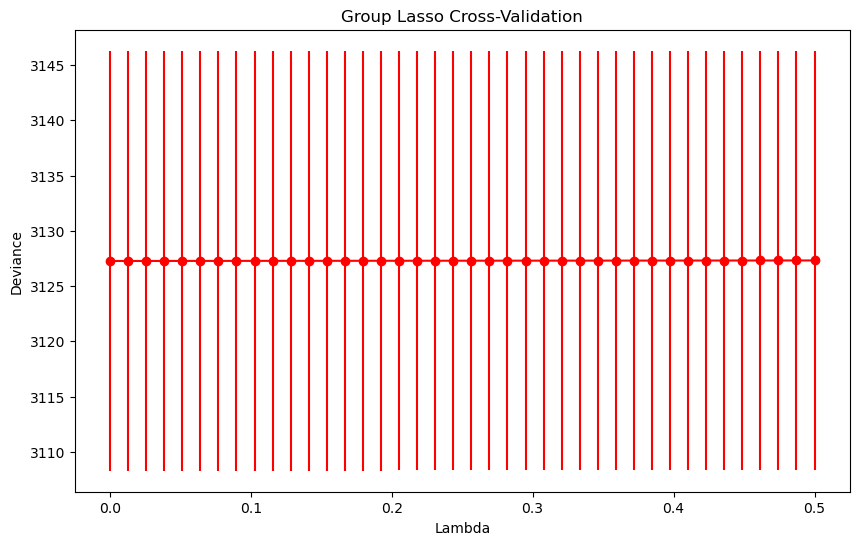

In [80]:
# Convert to NumPy arrays for plotting
mean_values_deviance = np.array(mean_values_deviance)
sd_values_deviance = np.array(sd_values_deviance)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_deviance, yerr=(sd_values_deviance / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Deviance")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

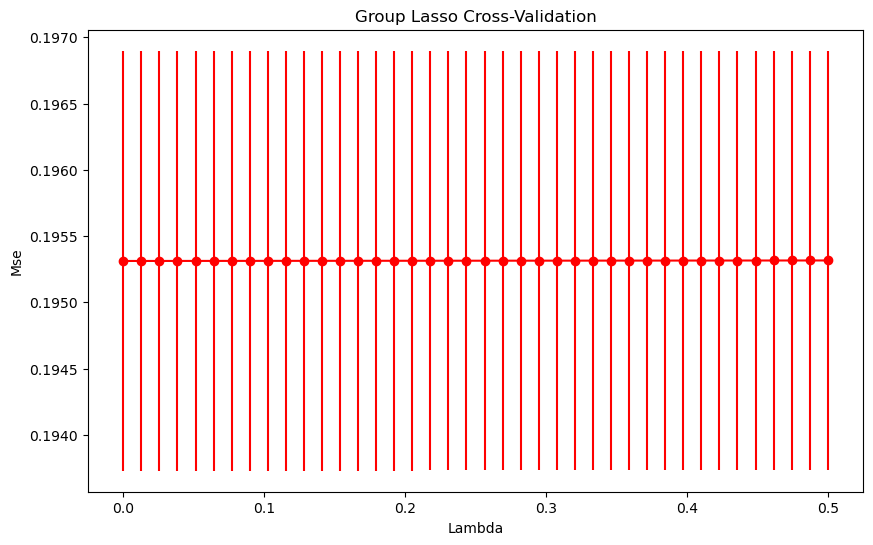

In [81]:
# Convert to NumPy arrays for plotting
mean_values_mse = np.array(mean_values_mse)
sd_values_mse = np.array(sd_values_mse)

# Plot the error bar graph
plt.figure(figsize=(10, 6))
plt.errorbar(lam_seq, mean_values_mse, yerr=(sd_values_mse / np.sqrt(kf.get_n_splits())), fmt='-', marker="o", ecolor="red", color="red")
plt.ylabel("Mse")
plt.xlabel("Lambda")
plt.title("Group Lasso Cross-Validation")
plt.show()

In [82]:
mean_values_mse

array([0.19531188, 0.19531198, 0.19531208, 0.19531218, 0.19531228,
       0.19531238, 0.19531248, 0.19531258, 0.19531268, 0.19531278,
       0.19531288, 0.19531298, 0.19531308, 0.19531318, 0.19531328,
       0.19531338, 0.19531348, 0.19531358, 0.19531368, 0.19531378,
       0.19531388, 0.19531398, 0.19531408, 0.19531418, 0.19531428,
       0.19531438, 0.19531448, 0.19531458, 0.19531468, 0.19531478,
       0.19531488, 0.19531498, 0.19531508, 0.19531518, 0.19531528,
       0.19531538, 0.19531548, 0.19531558, 0.19531568, 0.19531578])

In [84]:
# which is the lambda with the minimum mse?
min_mse = min(mean_values_mse)
min_mse_index = mean_values_mse.tolist().index(min_mse)

# print the lambda with the minimum mse
print("The lambda with the minimum mse is: ", lam_seq[min_mse_index])
print("The minimum mse is: ", min_mse)
print("It corresponds to the index: ", min_mse_index)

The lambda with the minimum mse is:  0.0001
The minimum mse is:  0.1953118759274362
It corresponds to the index:  0


### Logistic Group Lasso - grouped by same measure - lambda: 0.0001

In [ ]:
#implement group lasso on the train set

# define the groups for the features
groups = [1,2,3,4,5,6,7,8,9,10,11,12] * 200

# lambda value from the cross validation
lambda_value = 0.0001

# define the group lasso model
grp_lasso = LogisticGroupLasso(
    groups=groups, # the groups for the features
    group_reg=lambda_value, # the regularization parameter for the groups
    l1_reg=0, # the regularization parameter for the lasso penalty
    scale_reg="inverse_group_size", # scaling the regularization parameter by the size of the groups
    n_iter = 2000, # number of iterations
    tol=1e-20, # tolerance for the stopping condition
)

# fit the group lasso model on the train set
grp_lasso.fit(X_train, y_train)

# predict probabilities
pred = grp_lasso.predict_proba(X_test.values)[:, 1]

In [ ]:
# tranform pred into binary
pred = np.where(pred>0.5, 1, 0)

# calculate the accuracy score
accuracy = accuracy_score(y_test, pred)

# print the accuracy score
print("The accuracy score is: ", accuracy)

# print the precision score
print("The precision score is: ", precision_score(y_test, pred))

# print the recall score
print("The recall score is: ", recall_score(y_test, pred))

# print the coefficients of the model
print("The coefficients of the model are: ", grp_lasso.coef_[:, 1])

# print the intercept of the model
print("The intercept of the model is: ", grp_lasso.intercept_[1])

# print the groups of the model
print("The groups of the model are: ", grp_lasso.groups_[1])

# print the confusion matrix with headers
print("The confusion matrix is: ")
print(confusion_matrix_with_headers(y_test, pred))

The accuracy score is:  0.9103477167993297
The coefficients of the model are:  [-1.25327226e-04 -1.20480947e-04 -1.31071937e-05 ...  2.06970428e-07
  1.85450686e-06  2.86785036e-06]
The intercept of the model is:  -1.26624163734591
The groups of the model are:  [False  True False ... False False False]
The confusion matrix is: 
          Predicted 0  Predicted 1
Actual 0          991          155
Actual 1           59         1182
